# EEG Data Analysis

For this week's exercise you are going to get a dataset of raw EEG signals and using the Discrete Fourier Transform among other methods you will produce a clean dataset, ready to be classified for the assignment.

The data contains EEG measurements for people who were first asked to keep their eyes open (oa) and then closed (oc). We have split each recording into segments of 30 seconds.

In [1]:
import os
import re
import sys
import mne
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from os.path import join

import pandas as pd
from tqdm.notebook import tqdm

In [2]:
path_data = "data_for_exercise-50000-250"
data_oa = []
data_oc = []
sample_rate = 250   # DO NOT CHANGE THIS
n_subjects = -1

for folder in tqdm(os.listdir(path_data)[:n_subjects], desc="Loading data"):
    for filename in os.listdir(join(path_data, folder)):
        df = pd.read_csv(join(path_data, folder, filename), sep=",", index_col=0)
        if df.values.shape == (20, int(path_data.split("-")[-2])):
            if "oa" in filename:
                data_oa.append(df.values)
            else:
                data_oc.append(df.values)
        else:
            print(f"Wrong shape for {folder}/{filename}: {df.shape} when it should have been {20}-{int(path_data.split('-')[-2])}")

Loading data:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
print(F"Loaded {len(data_oa)} data segments")

Loaded 7 data segments


Now we want to center all the data around the same value, in eeg data analysis terms this is called referencing. Here we will apply a simple average referencing:

In [4]:
def set_reference(eeg_data, ref_channels):
    """Take the mean of the reference channels and subtract that from the data"""
    ref_signal = np.mean(eeg_data[ref_channels], axis=0)
    re_referenced_data = eeg_data - ref_signal
    return re_referenced_data

In [5]:
[el.shape for el in data_oa]

[(20, 50000),
 (20, 50000),
 (20, 50000),
 (20, 50000),
 (20, 50000),
 (20, 50000),
 (20, 50000)]

In [6]:
for i in range(len(data_oa)):
    data_oc[i] = set_reference(data_oc[i], np.arange(20))
    data_oa[i] = set_reference(data_oa[i], np.arange(20))

Let's take a look at the data:

In [7]:
def plot_eeg_mne_style(eeg_data, ch_names, sampling_rate):
    """
    Plot EEG data in an MNE-style plot for each channel.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    ch_names : list of str
        List of channel names (must be of length n_channels).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    """    
    # Create MNE info structure with channel names and sampling rate
    info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')
    
    # Create MNE RawArray object with the data
    raw = mne.io.RawArray(eeg_data, info)
    
    # Plot the EEG data with MNE's built-in plot function
    raw.plot(scalings='auto', show=True, block=True)
    plt.show()

Creating RawArray with float64 data, n_channels=20, n_times=50000
    Range : 0 ... 49999 =      0.000 ...   199.996 secs
Ready.
Using matplotlib as 2D backend.


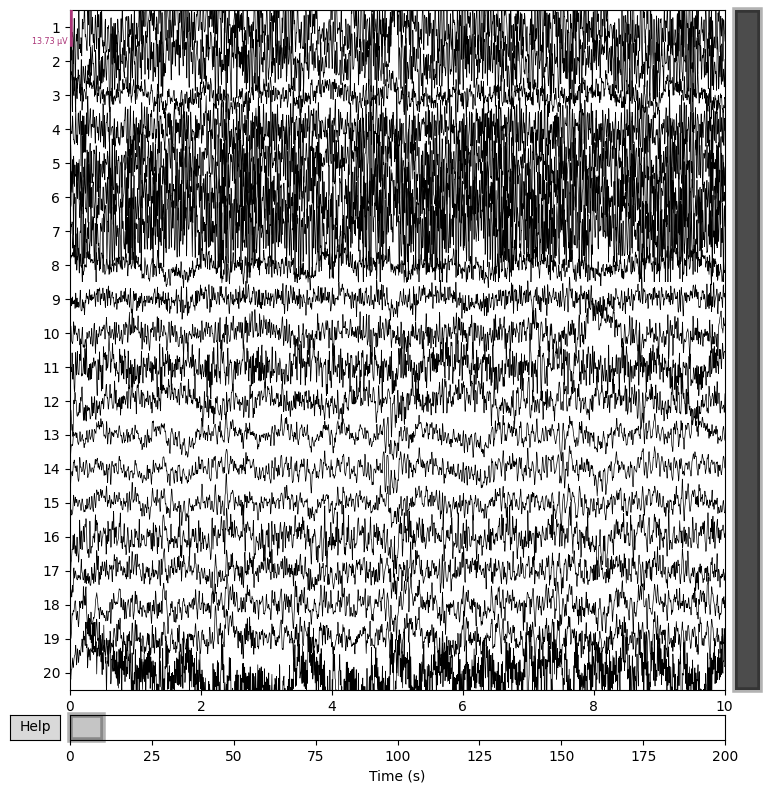

In [8]:
channel_names = np.arange(1,21,1).astype(str).tolist()
plot_eeg_mne_style(data_oa[4], ch_names=channel_names, sampling_rate=sample_rate)

From this there is very little the untrained eye can glean. Try plotting some of the other data to get a feel for whether this noisy plot is representative of the data.

Now we have the data loaded and centered. The next step is to decompose the signals into their frequency components using the DFT. In addition, we will implement masking of the output based on a minimum and maximum frequency. For EEG inspection we were recommended to look at the frequencies between 1-40 Hz.

In [9]:
def compute_power_spectrum(signal, sampling_rate, min_freq=None, max_freq=None):
    """
    Computes the power spectrum for each channel in the signal.

    Parameters:
    signal : np.ndarray
        Input signal with shape (n_channels, n_points)
    sampling_rate : float
        The sampling rate of the signal (in Hz).

    Returns:
    freqs : np.ndarray
        The frequencies corresponding to the power spectrum.
    power_spectrum : np.ndarray
        Power spectrum of each channel with shape (n_channels, n_points//2).
    """
    n_channels, n_points = signal.shape
    
    # Perform the FFT for each channel
    fft_vals = np.fft.rfft(signal, axis=1)
    
    # Compute the power spectrum (squared magnitude of the FFT)
    power_spectrum = np.abs(fft_vals) ** 2
    
    # Compute the corresponding frequencies
    freqs = np.fft.rfftfreq(n_points, 1 / sampling_rate)
    
    if min_freq is not None:
        power_spectrum = power_spectrum[:, freqs >= min_freq]
        freqs = freqs[freqs >= min_freq]

    if max_freq is not None:
        power_spectrum = power_spectrum[:, freqs <= max_freq]
        freqs = freqs[freqs <= max_freq]
    
    return freqs, power_spectrum

In [10]:
def plot_power_spectrum_overlay(freqs, power_spectrum, ch_names, show=False, title=""):
    """
    Plot the power spectrum for all channels on the same plot.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    ch_names : list of str
        List of channel names.
    """
    colors = cm.viridis(np.linspace(0, 1, len(ch_names)))

    for i, ch_name in enumerate(ch_names):
        plt.plot(freqs, power_spectrum[i], color=colors[i], label=ch_name)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.title('Power Spectrum for EEG Channels' if not title else title)
    plt.tight_layout()
    if show:
        plt.show()
    

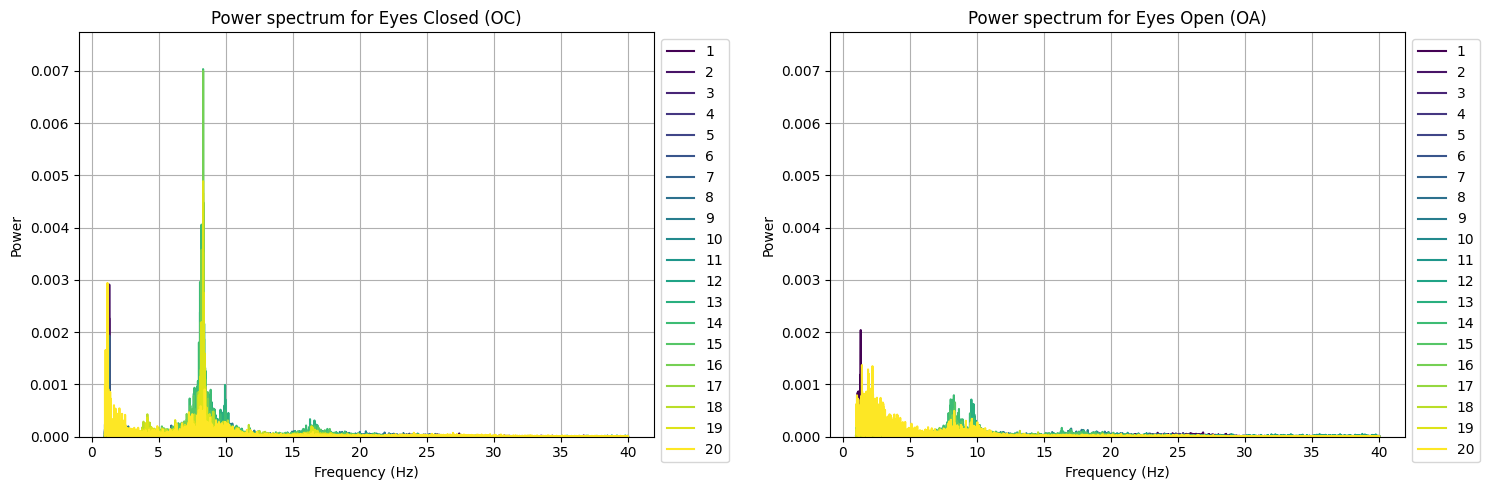

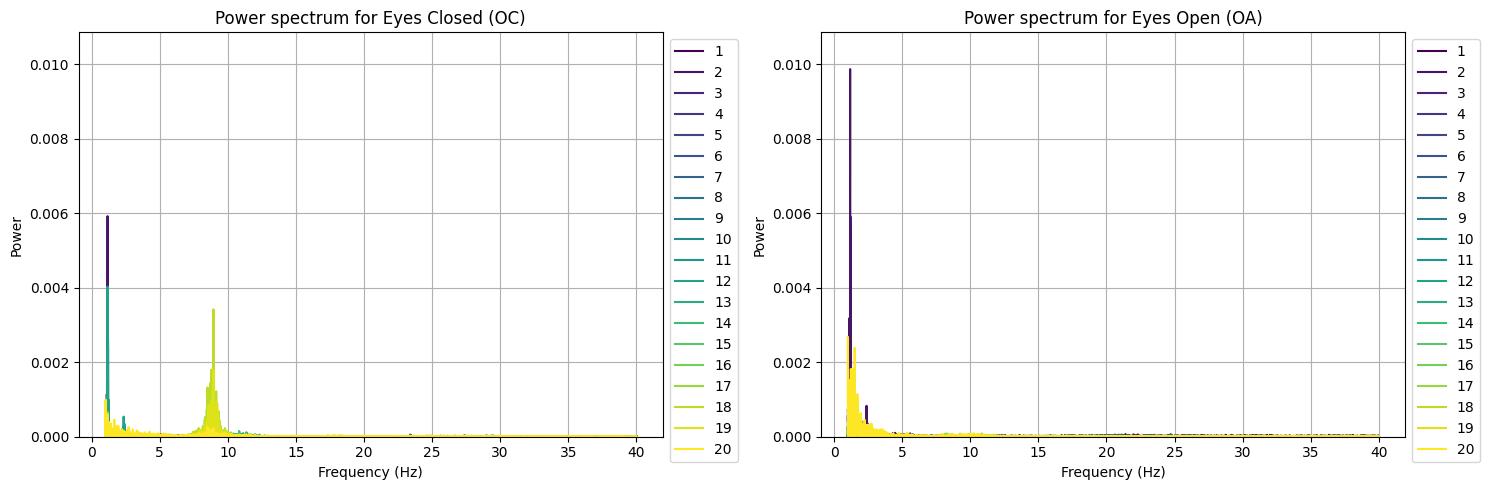

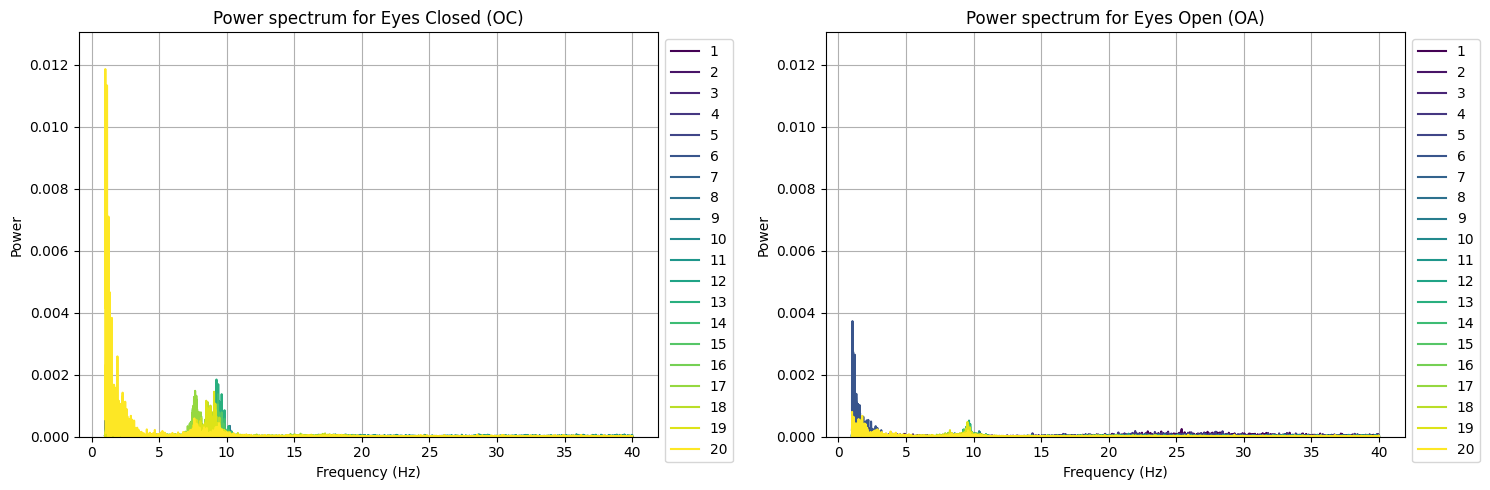

In [11]:
segments_to_plot = [0, 3, 5]
for segment in segments_to_plot:
    plt.subplots(1, 2, figsize=(15, 5))
    
    # Compute power spectra for both conditions
    freqs_oc, power_spectrum_oc = compute_power_spectrum(data_oc[segment], sampling_rate=sample_rate, min_freq=1, max_freq=40)
    freqs_oa, power_spectrum_oa = compute_power_spectrum(data_oa[segment], sampling_rate=sample_rate, min_freq=1, max_freq=40)
    
    # Determine the y-limit based on the maximum value of both power spectra
    y_max = max(power_spectrum_oc.max(), power_spectrum_oa.max())
    
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, power_spectrum_oc, channel_names, title=f"Power spectrum for Eyes Closed (OC)")
    plt.ylim([0, y_max + y_max / 10])
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, power_spectrum_oa, channel_names, title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim([0, y_max + y_max / 10])
    plt.show()

When comparing the eyes closed and eyes open spectrograms, is there a noticeable difference between the two. How could we use this difference for classification? Hints: using energy?  

We will now focus on two channels that we know are strongly correlated to open/closed eyes.

In [12]:
data_oc_optical_channels = [arr[17:19] for arr in data_oc]
data_oa_optical_channels = [arr[17:19] for arr in data_oa]

Now let's get the power spectra from the range that seems to be the most suited for classifying the difference between OC and OA:

In [13]:
min_freq = 1
max_freq = 20
power_spectra_oc = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr in data_oc_optical_channels]
power_spectra_oa = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr
                    in data_oa_optical_channels]

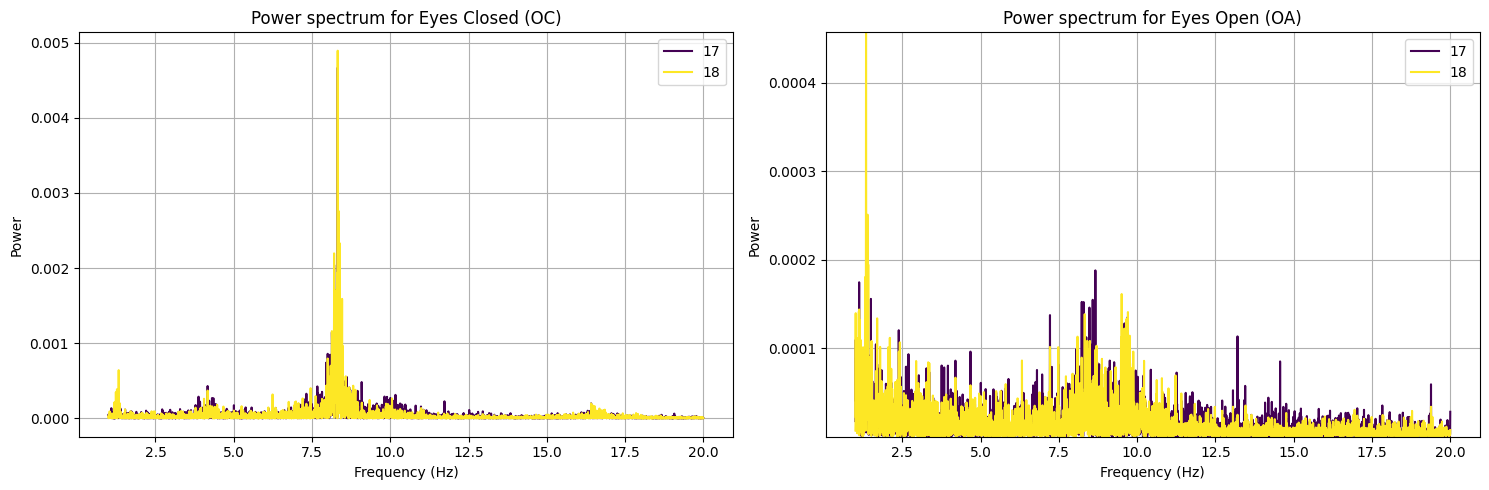

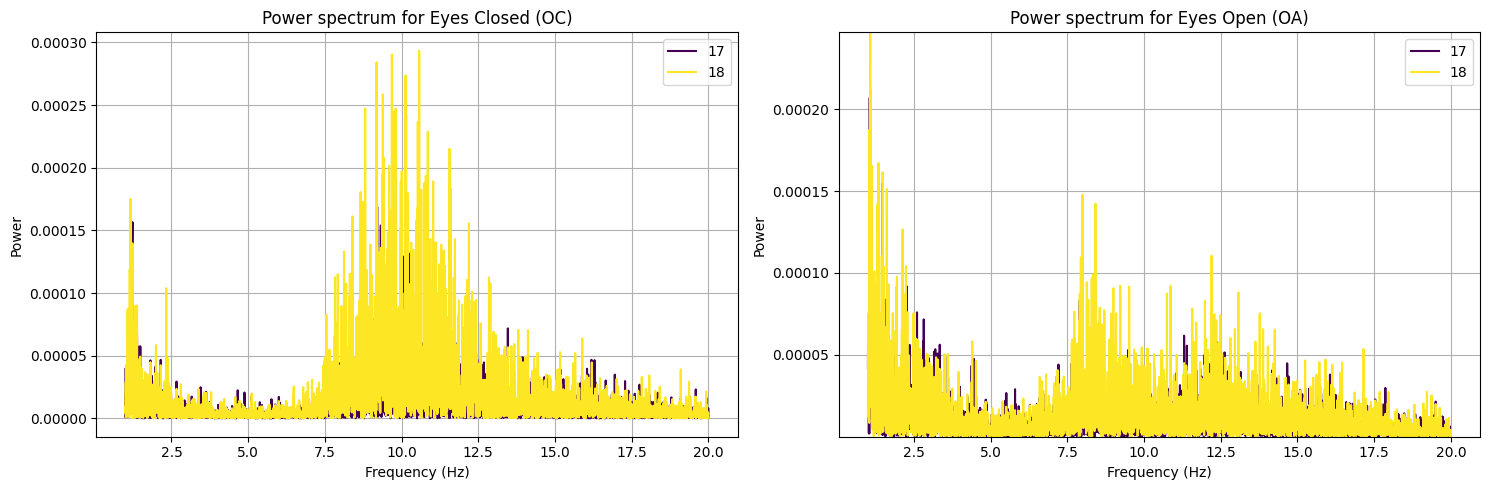

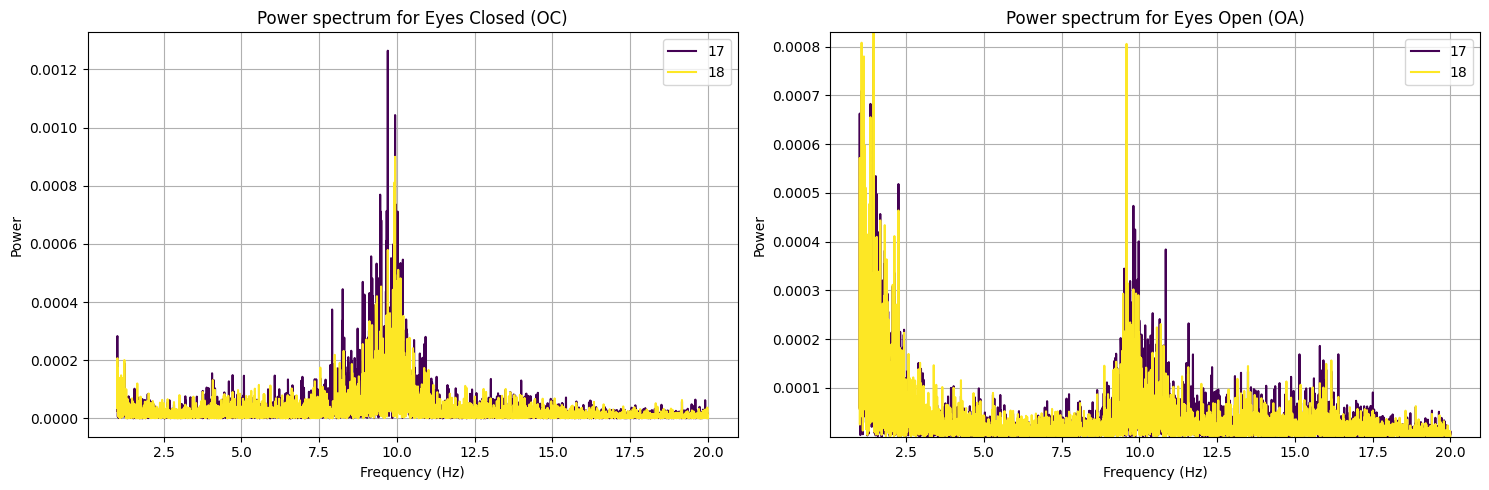

In [14]:
n_plots = 3
for (freqs_oc, spectrum_oc), (freqs_oa, spectrum_oa) in zip(power_spectra_oc, power_spectra_oa[:n_plots]):
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, spectrum_oc, ch_names=[17, 18], title=f"Power spectrum for Eyes Closed (OC)")
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, spectrum_oa, ch_names=[17, 18], title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim(spectrum_oc.min(), spectrum_oa.max())
    plt.show()

Now let's compute the sum of the energies in this range and plot them

In [15]:
alphas_oc = []
alphas_oa = []
for (freqs_oc, spectrum_oc), (freqs_oa, spectrum_oa) in zip(power_spectra_oc, power_spectra_oa):
    alpha_oc = np.sum(spectrum_oc)
    alpha_oa = np.sum(spectrum_oa)
    
    alphas_oc.append(alpha_oc)
    alphas_oa.append(alpha_oa)
alphas_oc = np.array(alphas_oc)
alphas_oa = np.array(alphas_oa)

In [16]:
def plot_alphas(alphas_oc, alphas_oa, show=False, s = 10):
    fig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.scatter(range(len(alphas_oc)), alphas_oc, label='OC', color='blue', s=s) 
    plt.scatter(range(len(alphas_oa)), alphas_oa, label='OA', color='orange', s=s)
    # The following line makes a line which you can change to illustrate a decision boundary:
    plt.hlines(3.0 * 1e-6, 0, len(alphas_oc), linestyles='dashed', color='red')
    plt.title('OA and OC energy of alpha frequencies compared')
    plt.xlabel('Subject')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.scatter(range(len(alphas_oc)), alphas_oc / alphas_oa, label='Ratio', color='red', s=s)
    plt.hlines(1, 0, len(alphas_oc), linestyles='dashed', color='red')
    plt.xlabel('Subject')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    if show:
        plt.show()

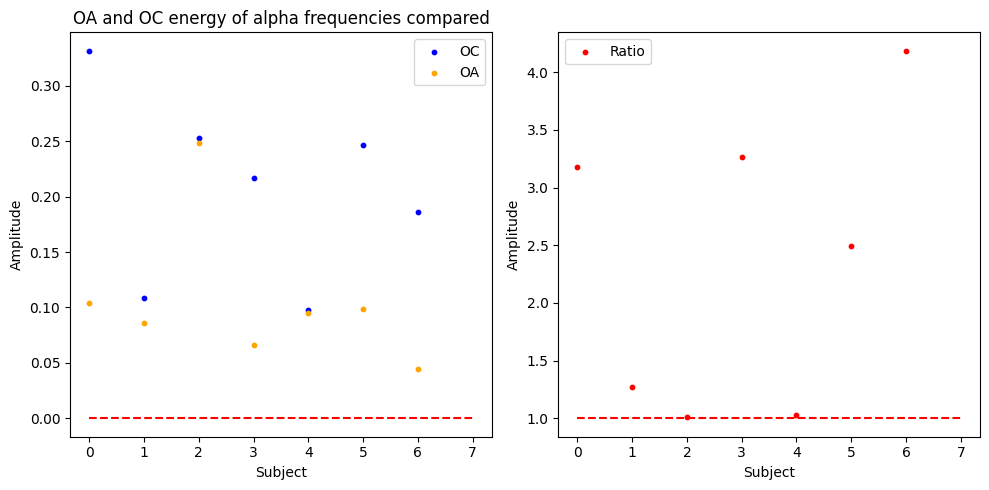

In [17]:
plot_alphas(alphas_oc, alphas_oa, show=True)

In [73]:
def cross_validation_split(data_oc, data_oa, hold_out_val, i, device, as_arrays=False):
    """
    Performs cross-validation split for one of time, frequency, or alpha data.
    
    Args:
        data_oc (list or array): Optical channels (oc) data.
        data_oa (list or array): Optical amplifiers (oa) data.
        hold_out_val (int): Number of elements to hold out in each fold.
        i (int): Current fold index.
    
    Returns:
        train_current (list or array): Training set for current fold.
        val_current (list or array): Validation set for current fold.
    """    
    # Define slices for validation and training sets
    slice_val = slice(i * hold_out_val, (i + 1) * hold_out_val)
    before_slice = slice(0, i * hold_out_val)
    after_slice = slice((i + 1) * hold_out_val, None)
    # Validation sets
    val_current_oc = data_oc[slice_val]
    val_current_oa = data_oa[slice_val]
    
    # Training sets (excluding validation slices)
    train_current_oc = data_oc[before_slice] + data_oc[after_slice]
    train_current_oa = data_oa[before_slice] + data_oa[after_slice]
    
    # Combine oc and oa for the current fold
    val_current = val_current_oc + val_current_oa
    train_current = train_current_oc + train_current_oa
    
    val_targets = [0 for _ in val_current_oc] + [1 for _ in val_current_oa]
    train_targets = [0 for _ in train_current_oc] + [1 for _ in train_current_oa]
    if as_arrays:
        return train_current_oc, train_current_oa, val_current_oc, val_current_oa
    else:
        train_set = SimpleDataset(train_current, train_targets, device)
        val_set = SimpleDataset(val_current, val_targets, device)
        
        return train_set, val_set
        

In [37]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

class CNN(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, lr=0.001):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.lr = lr
        self.define_network()
    
    def define_network(self):
        # Define layers as a torch.nn.Sequential object
        # This is pretty nice, since we can just go layers(input) to get output
        # Rather than having a bunch of functions in the forward function
        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=self.num_classes)
        ).to(device)
                
        # Loss function and optimizer, as you know, Adam is the meta
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

    def forward(self, x):
        return self.layers(x)

    def train(self, train_dataloader, epochs=1, val_dataloader=None, run_filepath=""):
        
        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []
        acc = None
        for epoch in tqdm(range(epochs), desc=f'Training'):
            
            path_epoch = join(run_filepath, f"{epoch}.pth")
            os.makedirs(os.path.dirname(path_epoch), exist_ok=True)
            if os.path.exists(path_epoch):
                print(path_epoch)
                self.load_model(path_epoch)
                print(f"Loaded model from {path_epoch}. Skipping epoch.")
                
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Not actually used for training, just for keeping track of accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            
            self.save_model(path_epoch)
            train_accs.append(epoch_acc / len(train_dataloader.dataset))
            print(f"Epoch {epoch} training accuracy: {epoch_acc}")

            # If we have val dataloader, we can evaluate after each epoch
            if val_dataloader is not None:
                acc = self.eval(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
        
        return train_accs, test_accs

    def eval(self, test_dataloader):
        
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            # Get predictions
            logits = self(input_batch)

            # Remember, outs are probabilities (so there's 10 for each input)
            # The classification the network wants to assign, must therefore be the probability with the larget value
            # We find that using argmax (dim=1, because dim=0 would be across batch dimension)
            classifications = torch.argmax(logits, dim=1)
            total_acc += (classifications == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc
    
    def save_model(self, path):
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optim.state_dict()
        }, path)
        print(f"Model saved to {path}")

    # Load model method
    def load_model(self, path):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Model loaded from {path}")

In [57]:
class FFNN(CNN):
    def __init__(self, num_classes, in_channels=1, lr=0.001):
        super().__init__(num_classes, in_channels, lr)
        
    def define_network(self):
        self.layers = torch.nn.Sequential(            
            nn.LazyLinear(out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=self.num_classes)
        ).to(device)
        self.criterion = nn.MSELoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

In [38]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SimpleDataset(Dataset):
    def __init__(self, time_data, targets, device, dtype_data=torch.float32, dtype_targets=torch.long):
        """
        Args:
            time_data (list or array): Training time data.
            targets (list or array): Corresponding target values (labels).
        """
        self.data = time_data
        self.targets = targets
        self.device = device
        self.dtype_data = dtype_data
        self.dtype_targets = dtype_targets

    def __len__(self):
        # Return the total number of samples
        assert len(self.data) == len(self.targets)
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single sample (time data and corresponding target)
        sample = self.data[idx]
        target = self.targets[idx]
        sample = torch.tensor(sample).to(dtype=self.dtype_data).to(device)
        target = torch.tensor(target).to(dtype=self.dtype_targets).to(device)
        if sample.ndim == 2:
            sample = sample.unsqueeze(0)
        
        # Optionally convert to torch tensors if needed
        return sample, target

The following is a VERY simple way of calculating a threshold. What could you do to make it more sophisticated?

In [71]:
def simple_threshold_calculator(vec1, vec2):
    m1 = np.mean(vec1)
    m2 = np.mean(vec2)
    return np.mean([m1, m2])

A simple classifier would be applying a threshold to the 

Cross validation loop:
- NN on frequency domain
- CNN on frequency domain
- CNN on Time domain [x]
- Threshold on alpha energy

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

run_name = join(os.getcwd(), "models", "testing-time-CNN")
hold_out_val = 1
hold_out_test = 2
epochs_CNN = 2

# Assuming the oc and oa data are already concatenated, split them back to separate.
train_set_time_oc = data_oc_optical_channels[:-hold_out_test]
train_set_time_oa = data_oa_optical_channels[:-hold_out_test]

train_set_frequency_oc = [el[1] for el in power_spectra_oc[:-hold_out_test]]
train_set_frequency_oa = [el[1] for el in power_spectra_oa[:-hold_out_test]]

train_set_alpha_oc = alphas_oc[:-hold_out_test]
train_set_alpha_oa = alphas_oa[:-hold_out_test]

Using cuda


In [68]:
val_accuracies_cnn_time = []

k_folds = len(train_set_alpha_oc) // hold_out_val
# Cross-validation loop
for i in tqdm(range(k_folds), desc="Cross-validation loop CNN time"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_time_oc, train_set_time_oa, hold_out_val, i, device=device)
    
    CNN_time = CNN(num_classes=2)
    CNN_time.train(DataLoader(train_set_current), epochs=epochs_CNN, run_filepath=f"{run_name}-{i}")
    val_cnn_time = CNN_time.eval(DataLoader(val_set_current))
    val_accuracies_cnn_time.append(val_cnn_time)

Cross-validation loop CNN time:   0%|          | 0/5 [00:00<?, ?it/s]

slice(0, 1, None)
slice(0, 0, None)
slice(1, None, None)


Training:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.79 GiB. GPU 0 has a total capacity of 3.00 GiB of which 0 bytes is free. Of the allocated memory 15.99 GiB is allocated by PyTorch, and 170.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [54]:
run_name = join(os.getcwd(), "models", "testing-freq-CNN")

val_accuracies_cnn_freq = []
for i in tqdm(range(k_folds), desc="Cross-validation loop CNN time"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_frequency_oc, train_set_frequency_oa, hold_out_val, i, device=device)
    
    CNN_freq = CNN(num_classes=2)
    CNN_freq.train(DataLoader(train_set_current), epochs=epochs_CNN, run_filepath=f"{run_name}-{i}")
    val_cnn_freq = CNN_freq.eval(DataLoader(val_set_current))
    val_accuracies_cnn_freq.append(val_cnn_freq)

Cross-validation loop CNN time:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model saved to C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\models\testing-freq-0\0.pth
Epoch 0 training accuracy: 3


  0%|          | 0/8 [00:00<?, ?it/s]

Model saved to C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\models\testing-freq-0\1.pth
Epoch 1 training accuracy: 0


Training:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model saved to C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\models\testing-freq-1\0.pth
Epoch 0 training accuracy: 3


  0%|          | 0/8 [00:00<?, ?it/s]

Model saved to C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\models\testing-freq-1\1.pth
Epoch 1 training accuracy: 0


Training:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model saved to C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\models\testing-freq-2\0.pth
Epoch 0 training accuracy: 4


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [59]:
run_name = join(os.getcwd(), "models", "testing-freq-FFNN")

val_accuracies_fnn_freq = []
for i in tqdm(range(k_folds), desc="Cross-validation loop CNN time"):
    # Combine oc and oa for the current fold
    train_set_current, val_set_current = cross_validation_split(train_set_frequency_oc, train_set_frequency_oa, hold_out_val, i, device=device)
    
    FFNN_freq = FFNN(num_classes=2)
    FFNN_freq.train(DataLoader(train_set_current), epochs=epochs_CNN, run_filepath=f"{run_name}-{i}")
    val_cnn_freq = FFNN_freq.eval(DataLoader(val_set_current))
    val_accuracies_fnn_freq.append(val_cnn_freq)

Cross-validation loop CNN time:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Model saved to C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\models\testing-freq-FFNN-0\0.pth
Epoch 0 training accuracy: 3


  0%|          | 0/8 [00:00<?, ?it/s]

Model saved to C:\Users\toell\OneDrive\Documents\GitHub\Signals-And-Data-Autumn-2024\week_5\models\testing-freq-FFNN-0\1.pth
Epoch 1 training accuracy: 0


Training:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [72]:
run_name = join(os.getcwd(), "models", "testing-freq-threshold")

val_accuracies_threshold = []
for i in tqdm(range(k_folds), desc="Cross-validation loop CNN time"):
    # Combine oc and oa for the current fold
    train_oc, train_oa, val_oc, val_oa = cross_validation_split(alphas_oc.tolist(), alphas_oa.tolist(), hold_out_val, i, device=device, as_arrays=True)
    
    threshold = simple_threshold_calculator(train_oc, train_oa)
    acc = (val_oc > threshold) + (threshold < val_oa)
    val_accuracies_threshold.append(acc)

Cross-validation loop CNN time:   0%|          | 0/5 [00:00<?, ?it/s]

slice(0, 1, None)
slice(0, 0, None)
slice(1, None, None)
slice(1, 2, None)
slice(0, 1, None)
slice(2, None, None)
slice(2, 3, None)
slice(0, 2, None)
slice(3, None, None)
slice(3, 4, None)
slice(0, 3, None)
slice(4, None, None)
slice(4, 5, None)
slice(0, 4, None)
slice(5, None, None)


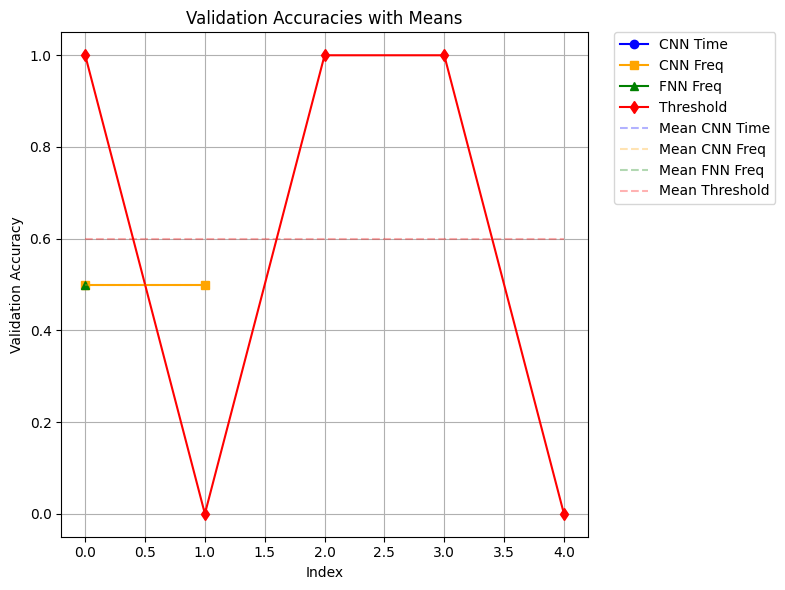

In [81]:
# Calculate means
# Small value to prevent division by zero
epsilon = 1e-8

# Calculate means
mean_cnn_time = [sum(val_accuracies_cnn_time) / (len(val_accuracies_cnn_time) + epsilon)] * len(val_accuracies_cnn_time)
mean_cnn_freq = [sum(val_accuracies_cnn_freq) / (len(val_accuracies_cnn_freq) + epsilon)] * len(val_accuracies_cnn_freq)
mean_fnn_freq = [sum(val_accuracies_fnn_freq) / (len(val_accuracies_fnn_freq) + epsilon)] * len(val_accuracies_fnn_freq)
mean_threshold = [sum(val_accuracies_threshold) / (len(val_accuracies_threshold) + epsilon)] * len(val_accuracies_threshold)

# Plotting
# Plotting
plt.figure(figsize=(8, 6))
cnn_time_color = 'blue'  # Example color for CNN Time
cnn_freq_color = 'orange'  # Example color for CNN Freq
fnn_freq_color = 'green'  # Example color for FNN Freq
threshold_color = 'red'  # Example color for Threshold

plt.plot(val_accuracies_cnn_time, label='CNN Time', marker='o', color=cnn_time_color)
plt.plot(val_accuracies_cnn_freq, label='CNN Freq', marker='s', color=cnn_freq_color)
plt.plot(val_accuracies_fnn_freq, label='FNN Freq', marker='^', color=fnn_freq_color)
plt.plot(val_accuracies_threshold, label='Threshold', marker='d', color=threshold_color)

# Plot means with low alpha, matching colors
plt.plot(mean_cnn_time, label='Mean CNN Time', linestyle='--', alpha=0.3, color=cnn_time_color)
plt.plot(mean_cnn_freq, label='Mean CNN Freq', linestyle='--', alpha=0.3, color=cnn_freq_color)
plt.plot(mean_fnn_freq, label='Mean FNN Freq', linestyle='--', alpha=0.3, color=fnn_freq_color)
plt.plot(mean_threshold, label='Mean Threshold', linestyle='--', alpha=0.3, color=threshold_color)

plt.title('Validation Accuracies with Means')
plt.xlabel('Index')
plt.ylabel('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


0

Try the above classification only including 